In [99]:
##############################################
# Manually construct behaviors               #
##############################################

# Packages
import pickle
import numpy as np
import time
import rospy
import rospkg
from corrective_shared_autonomy.TaskModels.DMPLWRhardcoded import HybridSegment
from corrective_shared_autonomy.TaskModels.DMPLWRhardcoded import DMPLWRhardcoded
from corrective_shared_autonomy.TaskModels.FragmentedExecution import interpMultD
from core_robotics.dataviz import threedplot, highlightedthreedplot
from core_robotics.PyBSpline import BSplineSurface
from scipy.spatial.transform import Rotation as ScipyR
from scipy.spatial.transform import Slerp
import matplotlib.pyplot as plt

rospy.init_node('subdivisiontester', anonymous=True)

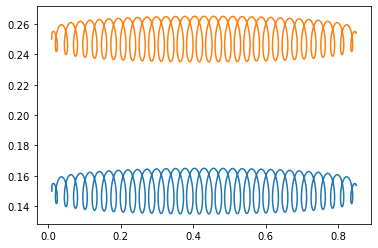

In [6]:
###################################################
# Red Overhead bin: IRC_piece1 ####################
###################################################

rospack = rospkg.RosPack()
uliconfigpath = rospack.get_path('uli_config')
config_dir = rospack.get_path('uli_config')+'/registration_models/'

outfile  = config_dir + 'IRC_piece1_2pass_frag.pkl'

ang_relative_to_surface = 0 # degree

tool_offset = np.array([-0.04, 0.0, 0.0])
state_names = ['u','v','f','theta_qx','theta_qy','theta_qz','theta_qw','delta_s','valve','tool_offset_x','tool_offset_y','tool_offset_z']
# starting = [[0.01, 0.04], [0.01, 0.09], [0.01, 0.15], [0.01, 0.25], [0.01, 0.35], [0.01, 0.45], [0.01, 0.55], [0.01, 0.65], [0.01, 0.75], [0.01, 0.85], [0.01, 0.91], [0.01, 0.96]]
# ending = [[0.85, 0.04], [0.85, 0.09], [0.85, 0.15], [0.85, 0.25], [0.85, 0.35], [0.85, 0.45], [0.85, 0.55], [0.85, 0.65], [0.85, 0.75], [0.85, 0.85], [0.85, 0.91], [0.85, 0.96]]
starting = [[0.01, 0.15], [0.01, 0.25]]
ending = [[0.85, 0.15], [0.85, 0.25]]

samps_per_sec = 40
# samps = samps_per_sec * np.array([10,10,10,10,10])
samps = samps_per_sec * np.array([80,80,80,80,80,80,80,80,80,80,80,80])
forces = np.array([-20.,-20.,-20.,-20.,-20.,-20.,-20.,-20.,-20.,-20.,-20, -20])
angs = np.array([-10,-10,-10,-10,-10,-10,-10,-10,-10,-10,-10,-10])

state_vals = []
for ii in range(0,len(starting)):
    R_tool_surf = ScipyR.from_euler('zy',[ang_relative_to_surface,angs[ii]],degrees=True)
    theta_q = R_tool_surf.as_quat()
    start_temp = np.array([starting[ii][0],starting[ii][1],forces[ii],theta_q[0],theta_q[1],theta_q[2],theta_q[3], 1.0, 1.0, tool_offset[0], tool_offset[1], tool_offset[2]])
    end_temp = np.array([ending[ii][0],ending[ii][1],forces[ii],theta_q[0],theta_q[1],theta_q[2],theta_q[3], 1.0, 1.0, tool_offset[0], tool_offset[1], tool_offset[2]])
#     state_vals.append(interpMultD(start_temp,end_temp,samps[ii],quat_vars=[3]))
    state_vals.append(interpMultD(start_temp,end_temp,samps[ii],quat_vars=[3],super_pos_vars=[0], super_pos_freq=[0.04], super_pos_amp=[0.015]))

# Plot 2D passes
for ii in range(0,len(starting)):
    plt.plot(state_vals[ii][0,:],state_vals[ii][1,:])
plt.show()
    
R_extra_tool = ScipyR.from_euler('y',-5,degrees=True)
q_extra = R_extra_tool.as_quat()
corrections = [[0.0, 0.0, -6.0, q_extra[0], q_extra[1], q_extra[2], q_extra[3], -0.5, 0.0, -0.01, 0.0, 0.0]]

pickle.dump((state_names,state_vals,corrections),open(outfile,"wb"), protocol=2)

Create 6 forward-backward paths, spanning from 0.2 to 0.8 with lateral spacing of 0.12
Created shortened path at beginning
Created shortened path at the end


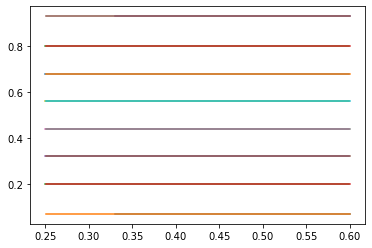

In [122]:
###################################################
# Anna Flat Piece ####################
###################################################

rospack = rospkg.RosPack()
uliconfigpath = rospack.get_path('uli_config')
config_dir = rospack.get_path('uli_config')+'/registration_models/'

outfile  = config_dir + 'anna_flat1_frag.pkl'

ang_relative_to_surface = 0 # degree

tool_offset = np.array([0.0, 0.0, 0.000])
state_names = ['u','v','f','theta_qx','theta_qy','theta_qz','theta_qw','delta_s','valve','tool_offset_x','tool_offset_y','tool_offset_z']
# delta_s: change in "speed" but more complicated (S is DMP specific term)

# length of starting and ending arrays = number of passes
# starting = [[0.01, 0.04], [0.01, 0.09], [0.01, 0.15], [0.01, 0.25], [0.01, 0.35], [0.01, 0.45], [0.01, 0.55], [0.01, 0.65], [0.01, 0.75], [0.01, 0.85], [0.01, 0.91], [0.01, 0.96]]
# ending = [[0.85, 0.04], [0.85, 0.09], [0.85, 0.15], [0.85, 0.25], [0.85, 0.35], [0.85, 0.45], [0.85, 0.55], [0.85, 0.65], [0.85, 0.75], [0.85, 0.85], [0.85, 0.91], [0.85, 0.96]]
near_edge = 0.25
far_edge = 0.6
lateral = 0.12 # min lateral dist. b/t paths should be ~0.12
num_paths = 6 # Default: 6
starting = []
ending = []
starting, ending = make_forward_backward_paths(num_paths, near_edge=near_edge, far_edge=far_edge, lateral_spacing=lateral) # MAX num_paths 6 paths


# Prepend shortened path to list of paths, to account for bolts fastening the piece
bolt_edge = 0.33
starting[:0] = [[bolt_edge, 0.07], [far_edge, 0.07]]
ending[:0] =   [[far_edge,  0.07], [near_edge, 0.07]]
print("Created shortened path at beginning")

# Append shortened path to list of paths, to account for bolts fastening the piece
starting.extend([[bolt_edge, 0.93], [far_edge, 0.93]])
ending.extend(  [[far_edge,  0.93], [near_edge, 0.93]])
print("Created shortened path at the end")

# print(starting)
# print(ending)


# dd = 0.0
# starting = [[edge1, 0.8-dd], [edge2, 0.8-dd]] 
# ending =   [[edge2, 0.8-dd], [edge1, 0.8-dd]]
# dd = 0.12
# starting.extend([[edge1, 0.8-dd], [edge2, 0.8-dd]])
# ending.extend(  [[edge2, 0.8-dd], [edge1, 0.8-dd]])

samps_per_sec = 40 #40 is hardcoded into FragmentedExecution.py
samps = samps_per_sec * np.array([ 25] * 20) # num samples affects task speed, as interpolation happens slower
forces =                np.array([-10.] * 20)
angs =                  np.array([-6., 6.] * 10)
x_ang_offset = 3

state_vals = []
# for each path...
for ii in range(0,len(starting)):
    R_tool_surf = ScipyR.from_euler('zyx',[ang_relative_to_surface,angs[ii], x_ang_offset],degrees=True) # 'z' in 'zy' is older term referring to tool/eef directionality
    theta_q = R_tool_surf.as_quat()
    start_temp = np.array([starting[ii][0],starting[ii][1],forces[ii],theta_q[0],theta_q[1],theta_q[2],theta_q[3], 1.0, 1.0, tool_offset[0], tool_offset[1], tool_offset[2]])
    end_temp = np.array([ending[ii][0],ending[ii][1],forces[ii],theta_q[0],theta_q[1],theta_q[2],theta_q[3], 1.0, 1.0, tool_offset[0], tool_offset[1], tool_offset[2]])
#     state_vals.append(interpMultD(start_temp,end_temp,samps[ii],quat_vars=[3]))
# super_pos_freq=[0.04] and super_pos_amp=[0.015]  were in below line
    state_vals.append(interpMultD(start_temp,end_temp,samps[ii],quat_vars=[3],super_pos_vars=[0], super_pos_freq=[0.00], super_pos_amp=[0.00]))

# Plot 2D passes
for ii in range(0,len(starting)):
    plt.plot(state_vals[ii][0,:],state_vals[ii][1,:])
plt.show()
    
R_extra_tool = ScipyR.from_euler('y',-5,degrees=True)
q_extra = R_extra_tool.as_quat()

# scalar on how corrections affect the system
corrections = [[0.0, 0.0, -6.0, q_extra[0], q_extra[1], q_extra[2], q_extra[3], -0.5, 0.0, -0.01, 0.0, 0.0]]

pickle.dump((state_names,state_vals,corrections),open(outfile,"wb"), protocol=2)

In [87]:
[-6, -6] + [-10] * 10
a = [[1,2], [3,6]]
print(a)
a.extend([[4,8]])
print(a)

a.insert(0,([-10, -20]))
print(a)
a[:0] = [[-30, -60]]
print(a)

a.extend([[5, 10]])
print(a)

[[1, 2], [3, 6]]
[[1, 2], [3, 6], [4, 8]]
[[-10, -20], [1, 2], [3, 6], [4, 8]]
[[-30, -60], [-10, -20], [1, 2], [3, 6], [4, 8]]
[[-30, -60], [-10, -20], [1, 2], [3, 6], [4, 8], [5, 10]]


In [26]:
np.array([1,2] * 2)

array([1, 2, 1, 2])

In [119]:
def make_forward_backward_paths(num_paths=7, near_edge=0.25, far_edge=0.6, lateral_spacing=0.13):
    edge1 = near_edge
    edge2 = far_edge
    num_paths = num_paths
    lateral_spacing = lateral_spacing
    starting = []
    ending = []
    start_lat_pos = 0.20
    
    if num_paths > 7:
        print("ERROR: Span of paths likely to fall off piece")
        return
    
    # bad code style, just so this part is easy to copy+paste if needed
    if num_paths > 0:
        starting = [[edge1, start_lat_pos], [edge2, start_lat_pos]]
        ending =   [[edge2, start_lat_pos], [edge1, start_lat_pos]]
    

    for path_idx in range(1, num_paths):
        lat = lateral_spacing * path_idx
        starting.extend([[edge1, start_lat_pos+lat], [edge2, start_lat_pos+lat]])
        ending.extend(  [[edge2, start_lat_pos+lat], [edge1, start_lat_pos+lat]])

        if path_idx == (num_paths-1):
            print("Create", num_paths, "forward-backward paths, spanning from", start_lat_pos, "to", 
                  0.2+lat, "with lateral spacing of", lateral_spacing)

    return starting, ending

# For testing:
make_forward_backward_paths()

Create 7 forward-backward paths, spanning from 0.2 to 0.98 with lateral spacing of 0.13


([[0.25, 0.2],
  [0.6, 0.2],
  [0.25, 0.33],
  [0.6, 0.33],
  [0.25, 0.46],
  [0.6, 0.46],
  [0.25, 0.5900000000000001],
  [0.6, 0.5900000000000001],
  [0.25, 0.72],
  [0.6, 0.72],
  [0.25, 0.8500000000000001],
  [0.6, 0.8500000000000001],
  [0.25, 0.98],
  [0.6, 0.98]],
 [[0.6, 0.2],
  [0.25, 0.2],
  [0.6, 0.33],
  [0.25, 0.33],
  [0.6, 0.46],
  [0.25, 0.46],
  [0.6, 0.5900000000000001],
  [0.25, 0.5900000000000001],
  [0.6, 0.72],
  [0.25, 0.72],
  [0.6, 0.8500000000000001],
  [0.25, 0.8500000000000001],
  [0.6, 0.98],
  [0.25, 0.98]])

In [46]:
0.1 + 0.2

0.30000000000000004

In [47]:
A = 0.2
for i in range(1, 6):
    b = A * i
    print(b)

0.2
0.4
0.6000000000000001
0.8
1.0
